In [26]:
from __future__ import division
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

### Set Parameters

In [27]:
# This flag will control whether models will be evaluated by partition or for complete data set.
# Can be True or False
evauluate_models_by_partition = True

In [28]:
# File names
featureimportance_table_file = "featureimportance_table.csv"
predictions_table_file = "predictions_table.csv"
lift_table_file = 'lift_table.csv'
prec_recall_table_file = 'prec_recall_threshold_table.csv'

target_col = 'Class_5'  # Target cloumn can be Class_3, Class_5, Class_6
price_classes = ['lowest', 'low', 'medium', 'high', 'highest']              # 5 classes
#price_classes = ['low', 'medium', 'high']                                   # 3 classes
#price_classes = ['lowest', 'low', 'medium', 'high', 'very high','highest']  # 6 classes
#price_classes = ['lowest_4','low_3','low_2','low_1','medium_low','medium_high','high_1','high_2','high_3','highest_4']
agg_column_names = ['State','QualityStarCluster']
partition_column = 'QualityStarCluster'

# Directories
Output_results_directory = 'QoS_Output_Results/'
partitioned_models_directory = 'Partitioned_Models/'
unpartitioned_models_directory = 'Unpartitioned_Models/'
unseen_scored_predictions = 'unseen_scored_predictions/'

In [29]:
directory_path = ''
directory_path_2 = ''
if (evauluate_models_by_partition == True):
    directory_path = Output_results_directory+partitioned_models_directory 
    directory_path_2 = Output_results_directory+partitioned_models_directory+unseen_scored_predictions 
elif(evauluate_models_by_partition == False):
    directory_path = Output_results_directory+unpartitioned_models_directory
    directory_path_2 = Output_results_directory+unpartitioned_models_directory+unseen_scored_predictions


In [30]:
print(directory_path)
print(directory_path_2)

QoS_Output_Results/Partitioned_Models/
QoS_Output_Results/Partitioned_Models/unseen_scored_predictions/


### Model Evaluation 

#### Display Output Samples Train/Validation, Test, Holdout

In [31]:
df_predict = pd.read_csv(directory_path+predictions_table_file)
df_predict2 = pd.read_csv(directory_path_2+predictions_table_file)

df_predict2_holdout = df_predict2[df_predict2['holdout_sample']==1]

display(df_predict.head(5))
display(df_predict2.head(5))
display(df_predict2_holdout.head(5))

test_dataframe = df_predict[(df_predict['TrainTest']=='test')]
train_dataframe = df_predict[(df_predict['TrainTest']=='train')]
print("train_shape=",train_dataframe.shape)
print("test_shape=",test_dataframe.shape)
if (train_dataframe.shape[0] == 0):
    train_dataframe = test_dataframe
    


,QualityStarCluster,Medicare_provider_number,Hospital_name,State,"Hospital_Compare_5-star_rating_(October_2018,_NA=Not_Available)",holdout_sample,Class_3,Class_5,Class_6,Class_10,Relative_price_for_outpatient_services,predict,TrainTest,Model
0,1Star,330286,Good Samaritan Hospital,NY,1.0,0,1,2,2,3,191.0,4,train,GBT
1,1Star,30024,St. Josephs Hospital & Medical\nCtr,AZ,2.0,0,2,4,4,7,291.0,4,train,GBT
2,1Star,50616,St. Johns Pleasant Valley\nHospital,CA,2.0,0,3,5,6,9,375.0,5,train,GBT
3,1Star,100029,North Shore Medical Center\nAnd Fmc C,FL,1.0,0,3,5,6,10,563.0,5,train,GBT
4,1Star,450742,Baylor Scott & White - Lake\nPointe,TX,1.0,0,3,5,6,10,546.0,5,train,GBT


,QualityStarCluster,Medicare_provider_number,Hospital_name,State,"Hospital_Compare_5-star_rating_(October_2018,_NA=Not_Available)",holdout_sample,Class_3,Class_5,Class_6,Class_10,Relative_price_for_outpatient_services,predict,TrainTest,Model
0,1Star,10001,Southeast Alabama Medical\nCenter,AL,2.0,0.0,1.0,1.0,1.0,1.0,122.0,1,test,GBT
1,1Star,390198,Millcreek Community Hospital,PA,2.0,0.0,1.0,1.0,1.0,1.0,143.0,1,test,GBT
2,1Star,390079,Robert Packer Hospital,PA,2.0,1.0,3.0,5.0,6.0,9.0,385.0,3,test,GBT
3,1Star,390076,Brandywine Hospital,PA,2.0,0.0,1.0,1.0,1.0,2.0,156.0,4,test,GBT
4,1Star,390073,Altoona Regional Health\nSystem,PA,2.0,1.0,1.0,2.0,2.0,3.0,204.0,2,test,GBT


,QualityStarCluster,Medicare_provider_number,Hospital_name,State,"Hospital_Compare_5-star_rating_(October_2018,_NA=Not_Available)",holdout_sample,Class_3,Class_5,Class_6,Class_10,Relative_price_for_outpatient_services,predict,TrainTest,Model
2,1Star,390079,Robert Packer Hospital,PA,2.0,1.0,3.0,5.0,6.0,9.0,385.0,3,test,GBT
4,1Star,390073,Altoona Regional Health\nSystem,PA,2.0,1.0,1.0,2.0,2.0,3.0,204.0,2,test,GBT
23,1Star,370094,Alliancehealth Midwest,OK,1.0,1.0,1.0,2.0,2.0,3.0,201.0,3,test,GBT
43,1Star,420002,Piedmont Medical Center,SC,1.0,1.0,3.0,5.0,6.0,10.0,411.0,2,test,GBT
95,1Star,390001,Community Medical Center,PA,2.0,1.0,2.0,2.0,3.0,4.0,218.0,4,test,GBT


train_shape= (2358, 14)
test_shape= (592, 14)


#### Price by Quality Star Cluster Distribution

[Text(0, 0, 'low'), Text(0, 0, 'medium'), Text(0, 0, 'high')]

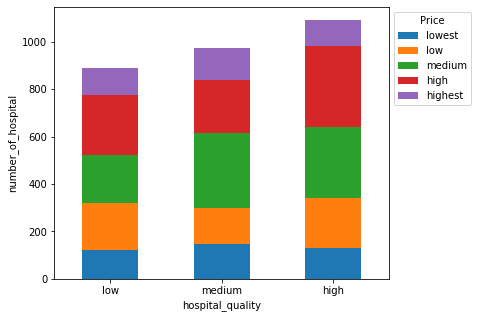

In [32]:
fig, ax = plt.subplots()
#predictions_table can be replaced by train_dataframe or test_dataframe
df_plot = df_predict.groupby(['predict', 'QualityStarCluster']).size().reset_index().pivot(columns='predict', index='QualityStarCluster', values=0)
df_plot.plot(kind='bar', stacked=True, figsize=(6,5), ax=ax)
ax.legend(price_classes,bbox_to_anchor=(1.0, 1.0),title='Price')
ax.set_xlabel('hospital_quality')
ax.set_ylabel('number_of_hospital')
ax.set_xticklabels(['low','medium','high'], rotation=360)

Text(0.5, 1, 'Normalized - Training 2018 High Quality Cluster')

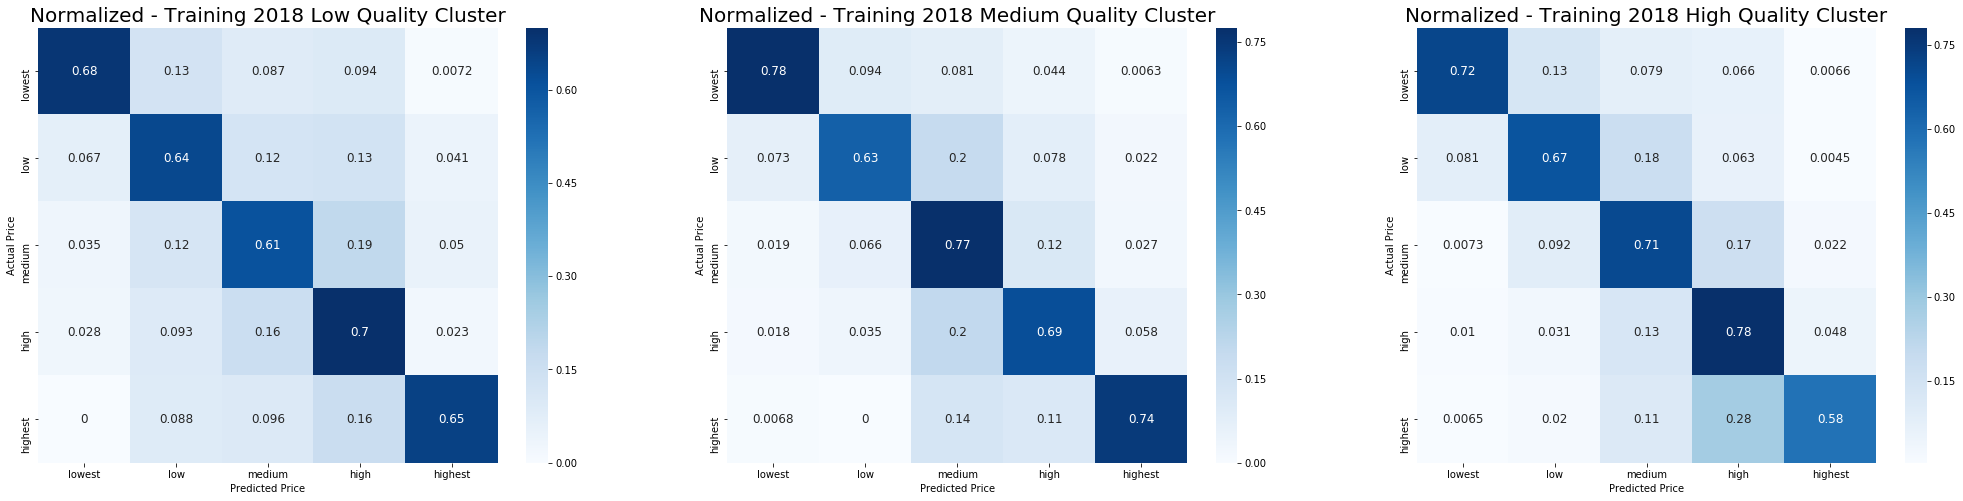

In [33]:
#By cluster train
cm1 = confusion_matrix(df_predict.loc[df_predict.QualityStarCluster == '1Star'][target_col], df_predict.loc[df_predict.QualityStarCluster == '1Star']['predict'], normalize='true')
cm_matrix = pd.DataFrame(data=cm1, columns=price_classes, index=price_classes)
fig = plt.figure(figsize=(35,8))
fig.add_subplot(1, 3, 1)
ax = sns.heatmap(cm_matrix, annot=True, annot_kws={"size": 12}, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price')
ax.set_title('Normalized - Training 2018 Low Quality Cluster',fontsize=20)

cm2 = confusion_matrix(df_predict.loc[df_predict.QualityStarCluster == '2Star'][target_col], df_predict.loc[df_predict.QualityStarCluster == '2Star']['predict'], normalize='true')
cm_matrix = pd.DataFrame(data=cm2, columns=price_classes, index=price_classes)
fig.add_subplot(1, 3, 2)
ax = sns.heatmap(cm_matrix, annot=True, annot_kws={"size": 12}, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price')
ax.set_title('Normalized - Training 2018 Medium Quality Cluster',fontsize=20)

cm3 = confusion_matrix(df_predict.loc[df_predict.QualityStarCluster == '3Star'][target_col], df_predict.loc[df_predict.QualityStarCluster == '3Star']['predict'], normalize='true')
cm_matrix = pd.DataFrame(data=cm3, columns=price_classes, index=price_classes)
fig.add_subplot(1, 3, 3)
ax = sns.heatmap(cm_matrix, annot=True, annot_kws={"size": 12}, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price')
ax.set_title('Normalized - Training 2018 High Quality Cluster',fontsize=20)

#### Training & Validation Set Evaluation (Normalized)

Text(0.5, 1, 'Normalized - Validation 2018')

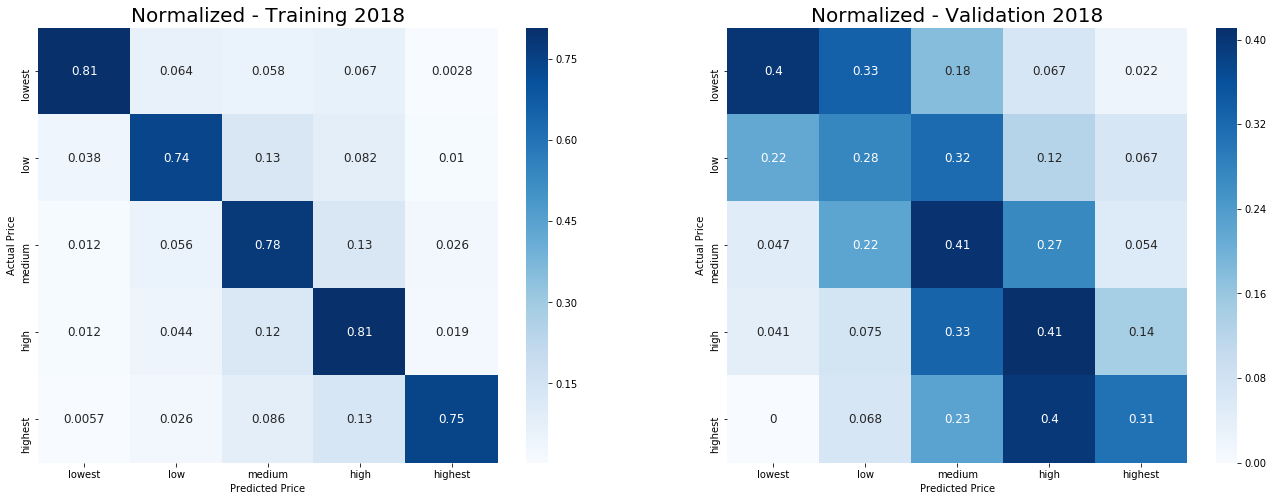

In [34]:
#train
cm = confusion_matrix(df_predict.loc[df_predict.TrainTest == 'train'][target_col], df_predict.loc[df_predict.TrainTest == 'train']['predict'], normalize='true')
cm_matrix = pd.DataFrame(data=cm, columns=price_classes, index=price_classes)
#fig = plt.figure(figsize=(8,6))
fig = plt.figure(figsize=(35,8))
fig.add_subplot(1, 3, 1)
ax = sns.heatmap(cm_matrix, annot=True, annot_kws={"size": 12}, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price')
ax.set_title('Normalized - Training 2018',fontsize=20)


#test
cm2 = confusion_matrix(df_predict.loc[df_predict.TrainTest == 'test'][target_col], df_predict.loc[df_predict.TrainTest == 'test']['predict'], normalize='true')
cm_matrix = pd.DataFrame(data=cm2, columns=price_classes, index=price_classes)
fig.add_subplot(1, 3, 2)
ax = sns.heatmap(cm_matrix, annot=True, annot_kws={"size": 12}, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price')
ax.set_title('Normalized - Validation 2018',fontsize=20)


#### Unseen Test & Holout Set Evaluation (Normalized)

Text(0.5, 1, 'Normalized - Unseen Holdout 2019')

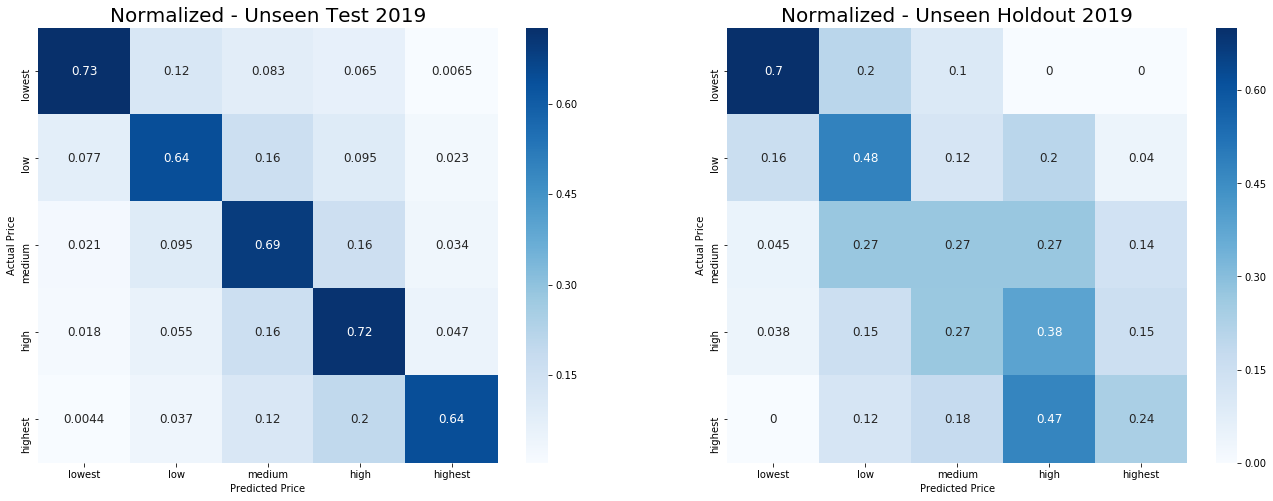

In [35]:
#unseen test
cm = confusion_matrix(df_predict2[target_col], df_predict2['predict'], normalize='true')
cm_matrix = pd.DataFrame(data=cm, columns=price_classes, index=price_classes)
#fig = plt.figure(figsize=(8,6))
fig = plt.figure(figsize=(35,8))
fig.add_subplot(1, 3, 1)
ax = sns.heatmap(cm_matrix, annot=True, annot_kws={"size": 12}, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price')
ax.set_title('Normalized - Unseen Test 2019',fontsize=20)

#holdout
cm2 = confusion_matrix(df_predict2_holdout[target_col], df_predict2_holdout['predict'], normalize='true')
cm_matrix = pd.DataFrame(data=cm2, columns=price_classes, index=price_classes)
fig.add_subplot(1, 3, 2)
ax = sns.heatmap(cm_matrix, annot=True, annot_kws={"size": 12}, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price')
ax.set_title('Normalized - Unseen Holdout 2019',fontsize=20)

#### Unseen Test & Holout Set Evaluation (Un-Normalized)

Text(0.5, 1, 'Unseen Holdout 2019')

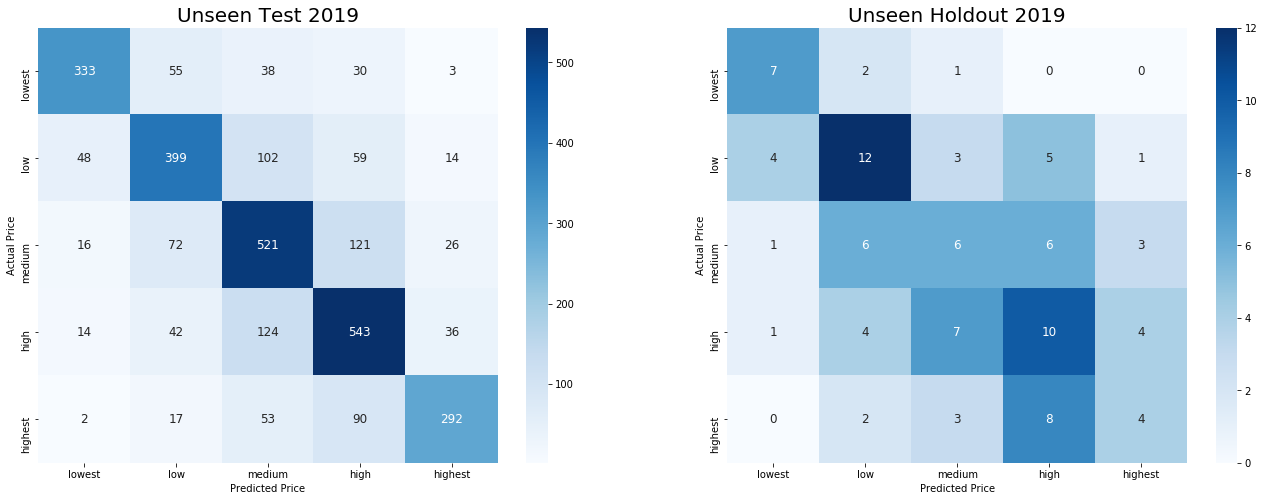

In [36]:
#unseen test
cm = confusion_matrix(df_predict2[target_col], df_predict2['predict'], normalize=None)
cm_matrix = pd.DataFrame(data=cm, columns=price_classes, index=price_classes)
#fig = plt.figure(figsize=(8,6))
fig = plt.figure(figsize=(35,8))
fig.add_subplot(1, 3, 1)
ax = sns.heatmap(cm_matrix, annot=True, annot_kws={"size": 12}, cmap='Blues',fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price')
ax.set_title('Unseen Test 2019',fontsize=20)


#holdout
cm2 = confusion_matrix(df_predict2_holdout[target_col], df_predict2_holdout['predict'], normalize=None)
cm_matrix = pd.DataFrame(data=cm2, columns=price_classes, index=price_classes)
fig.add_subplot(1, 3, 2)
ax = sns.heatmap(cm_matrix, annot=True, annot_kws={"size": 12}, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel('Predicted Price')
ax.set_ylabel('Actual Price')
ax.set_title('Unseen Holdout 2019',fontsize=20)